In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import cvxpy as cp
import os

In [4]:
folder = 'imgs'
if not os.path.exists(folder):
    os.makedirs(folder)

parameter we use

In [5]:
N = 100 # number of  nodes or sensors
R = 30 # radius of the communication range
L = 100 # length of the square area

x_gt = 0 # ground truth value for node data
x_cov = 1 # covariance of the sample


In [6]:

# random generate points uniformly in a square
points = np.random.uniform(0, L, size=(N, 2))
# check connectivity
G = nx.Graph()
G.add_nodes_from(range(N))
# add edges based on distance
for i in range(N):
    for j in range(i + 1, N):
        if np.linalg.norm(points[i] - points[j]) <= R:
            G.add_edge(i, j)

# check if connected
is_connected = nx.is_connected(G)
print(f"Graph is connected: {is_connected}")





Graph is connected: True


### P2

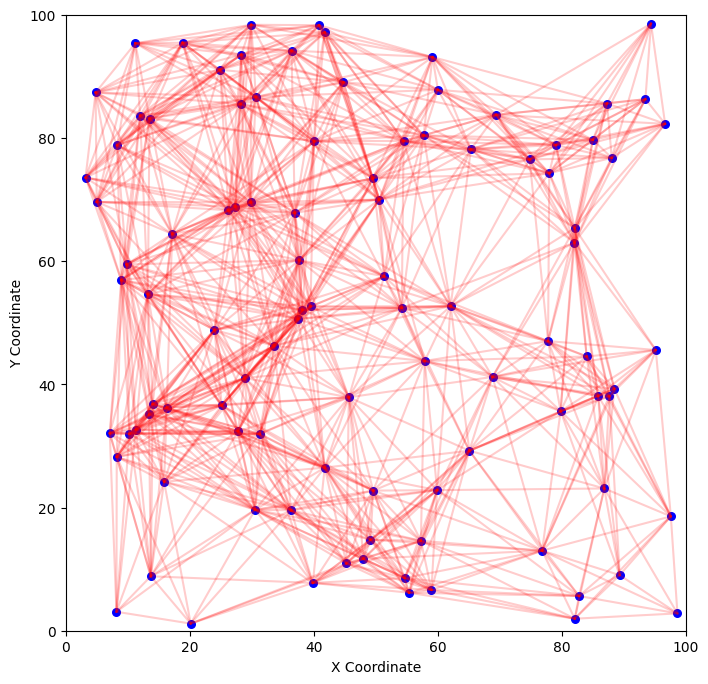

In [7]:
# plot the graph in right location
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], s=30, color='blue', label='Nodes')
for edge in G.edges():
    plt.plot(*zip(points[edge[0]], points[edge[1]]), color='red', alpha=0.2)
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# output this figure to a file
plt.savefig(os.path.join(folder, 'graph.png'))


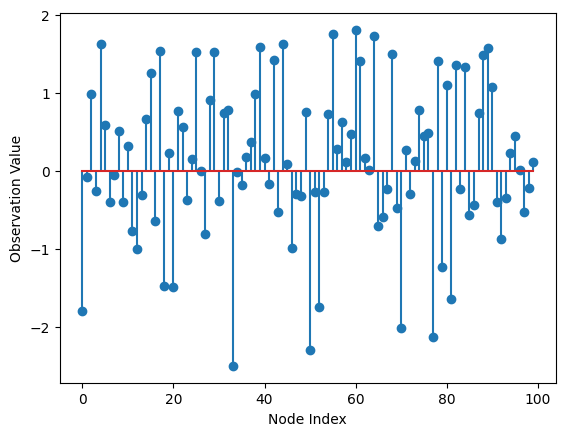

In [8]:

MAX_ITERS = int(2e5)

x_init = (x_gt + np.random.randn(N)*np.sqrt(x_cov)).reshape(N, 1) # initial obs

plt.stem(x_init)
# x label node index
plt.xlabel('Node Index')
plt.ylabel('Observation Value')

mu_x = x_init.mean()
mu_x_1 = np.ones((N,1)) * mu_x # x mean times ones vector
plt.savefig(os.path.join(folder, 'init_obs.png'))



random_gossip

\begin{array}{ll}
\operatorname{minimize} & \lambda_2(\bar{W}) \\
\text { subject to } & P \in \mathcal{S} \\
& p_{i j} \geq 0, \sum_{j \in \mathcal{V}} p_{i j}=1, \forall i \in \mathcal{V} \\
& \bar{W}=\frac{1}{n} \sum_{(i, j) \in \mathcal{E}} p_{i j} W_{i j}
\end{array}

\begin{aligned}
&\text { The entries of } \mathbb{E}\{W(k)\}=\bar{W}=\left(\bar{w}_{i j}\right) \text { are given by }\\
&\bar{w}_{i j}= \begin{cases}\left(p_{i j}+p_{j i}\right) /(2 n), & i \neq j \\ 1-\left(\sum_{j \in \mathcal{N}_i}\left(p_{i j}+p_{j i}\right)\right) /(2 n), & i=j\end{cases}
\end{aligned}

In [9]:
# # Assumes G, N already exist
# import numpy as np, cvxpy as cp
# from scipy.sparse import coo_matrix

# # directed edge list
# nbrs = {i: sorted(G.neighbors(i)) for i in G.nodes()}
# edges = [(i, j) for i in G.nodes() for j in nbrs[i]]
# m = len(edges)

# p = cp.Variable(m)                        # one var per directed edge
# row_sum = {i: [] for i in G.nodes()}      # index buckets per row
# for k, (i, _) in enumerate(edges):
#     row_sum[i].append(k)

# # sparse build: vec(W̄−I) = E @ p
# rows, cols, data = [], [], []
# s = 1/(2*N)
# for k, (i, j) in enumerate(edges):
#     rows += [i*N+j, j*N+i, i*N+i, j*N+j]
#     cols += [k,       k,       k,      k]
#     data += [s,       s,      -s,     -s]
# E = coo_matrix((data, (rows, cols)), shape=(N*N, m)).tocsc()
# W_vec = E @ p + np.eye(N).reshape(-1)
# W = cp.reshape(W_vec, (N, N))

# # constraints
# constr = [cp.sum(cp.hstack([p[idx] for idx in row_sum[i]])) == 1 for i in G.nodes()]
# constr += [p >= 0]

# J = np.ones((N, N))/N
# prob = cp.Problem(cp.Minimize(cp.lambda_max(W - J)), constr)
# prob.solve(solver= 'MOSEK'
#            ,verbose=True)




In [10]:
# \begin{aligned}
# &\text { The entries of } \mathbb{E}\{W(k)\}=\bar{W}=\left(\bar{w}_{i j}\right) \text { are given by }\\
# &\bar{w}_{i j}= \begin{cases}\left(p_{i j}+p_{j i}\right) /(2 n), & i \neq j \\ 1-\left(\sum_{j \in \mathcal{N}_i}\left(p_{i j}+p_{j i}\right)\right) /(2 n), & i=j\end{cases}
# \end{aligned}


P = cp.Variable((N, N), nonneg=True)  # adjacency matrix


W_bar = cp.Variable((N, N), nonneg=True)  # expected weight matrix
# row sum is 1
constraints = [cp.sum(P, axis=1) == 1]
# for i in range(N):
#     for j in range(N):
#         if i != j:
#             W_bar[i, j] = (P[i, j] + P[j, i]) / (2 * N)
#         else:
#             # diagonal entries
#             W_bar[i, j] = 1 - (cp.sum(P[i, :]) + cp.sum(P[:, i])) / (2 * N)
for i in range(N):
    for j in range(i,N):
        if i != j:
            constraints.append(W_bar[i, j] == (P[i, j] + P[j, i]) / (2 * N))
        else:
            # diagonal entries
            constraints.append(W_bar[i, j] == 1 - (cp.sum(P[i, :]) + cp.sum(P[:, i])) / (2 * N))

A = nx.adjacency_matrix(G).todense()
# non zero indices of A
non_edges = np.argwhere(A == 0)
for ind in non_edges:
    constraints.append(P[ind[0], ind[1]] == 0)


# solve problem optimize the eigen value of W_bar
J = np.ones((N, N)) / N
objective = cp.Minimize(cp.lambda_max(W_bar - J))
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True)
neigh_probs = {i: [float(P.value[i, j]) for j in G.neighbors(i)] for i in G.nodes()}

(CVXPY) Jun 25 10:29:37 AM: Your problem has 20000 variables, 13074 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jun 25 10:29:38 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 25 10:29:38 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 25 10:29:38 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 25 10:29:38 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jun 25 10:29:38 AM: Compiling problem (target solver=SCS).
(CVXPY) Jun 25 10:29:38 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jun 25 10:29:38 AM: Applying reduction Dcp2Cone


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jun 25 10:29:39 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 25 10:29:39 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Jun 25 10:29:46 AM: Applying reduction SCS
(CVXPY) Jun 25 10:29:47 AM: Finished problem compilation (took 8.906e+00 seconds).
(CVXPY) Jun 25 10:29:47 AM: Invoking solver SCS  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 20001, constraints m: 43074
cones: 	  z: primal zero / dual free vars: 18024
	  l: linear vars: 20000
	  s: psd vars: 5050, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 92774, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua

(CVXPY) Jun 25 10:29:54 AM: Problem status: optimal
(CVXPY) Jun 25 10:29:54 AM: Optimal value: 9.979e-01
(CVXPY) Jun 25 10:29:54 AM: Compilation took 8.906e+00 seconds
(CVXPY) Jun 25 10:29:54 AM: Solver (including time spent in interface) took 7.572e+00 seconds


  4425| 1.41e-05  5.24e-06  1.89e-05  9.98e-01  1.00e-01  7.57e+00 
------------------------------------------------------------------
status:  solved
timings: total: 7.57e+00s = setup: 2.56e-02s + solve: 7.54e+00s
	 lin-sys: 2.93e+00s, cones: 4.16e+00s, accel: 7.51e-02s
------------------------------------------------------------------
objective = 0.997885
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


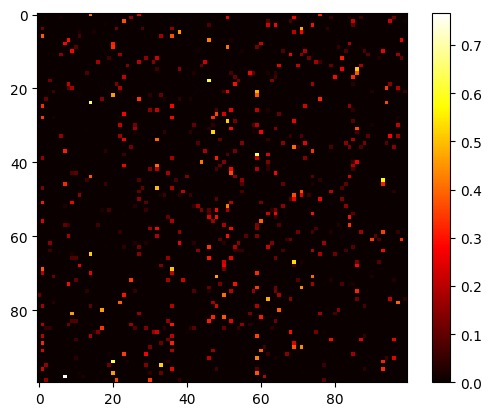

In [11]:

plt.imshow(P.value, cmap='hot')
plt.colorbar()
# plt.title('Probability Matrix P')
plt.savefig(os.path.join(folder, 'probability_matrix.png'))

In [12]:
neigh_list = {i: list(G.neighbors(i)) for i in G.nodes}
# # Pre‑compute neighbour probabilities p_{ij}=1/deg(i)
neigh_probs = {i: [1/len(list(G.neighbors(i)))]*len(list(G.neighbors(i)))
               for i in G.nodes}

neigh_probs = {i: [float(P.value[i, j]) for j in G.neighbors(i)] for i in G.nodes()}

A = nx.adjacency_matrix(G).todense()
deg = A.sum(axis=1)  
# neigh_probs = neigh_probs * A
# P = A / deg[:, None]         

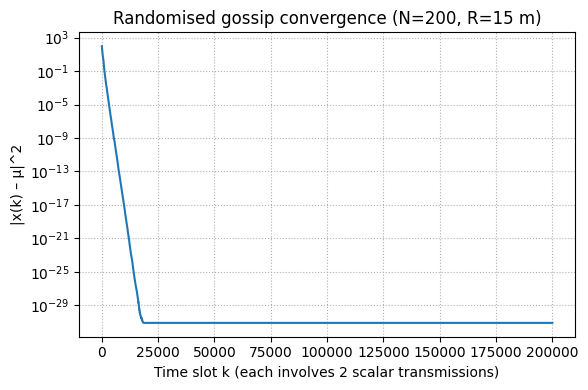

In [13]:
x = x_init.copy()            # initial state

# ---------------- randomised gossip simulation ----------------
xs = []              # record x after each time slot
errors = []            # mean absolute error after each time slot
for k in range(MAX_ITERS):
    # record error *before* update
    errors.append(np.linalg.norm(x - mu_x_1)**2)

    # pick node i uniformly, then neighbour j with prob p_{ij}
    i = random.randrange(N)
    j = random.choices(neigh_list[i], weights=neigh_probs[i])[0]

    avg = 0.5 * (x[i] + x[j])
    x[i] = avg
    x[j] = avg
    xs.append(x.copy())


# ---------------- plot error vs. time slots (iterations) ----------------
plt.figure(figsize=(6,4))
plt.semilogy(errors, linewidth=1.5)
plt.xlabel("Time slot k (each involves 2 scalar transmissions)")
plt.ylabel("|x(k) – μ|^2")
plt.title("Randomised gossip convergence (N=200, R=15 m)")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


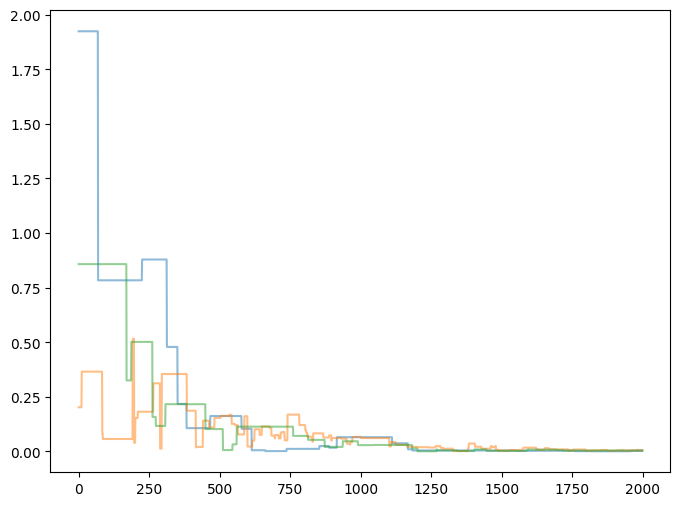

In [14]:
# plot xs
plt.figure(figsize=(8, 6))
xs = np.array(xs)
for i in range(3):
# for i in range(1):
    plt.plot(np.abs(xs[:2000, i]-mu_x), label=f'Node {i}', alpha=0.5)
    # plt.plot(xs[:25000, i]-mu_x, label=f'Node {i}', alpha=0.5)

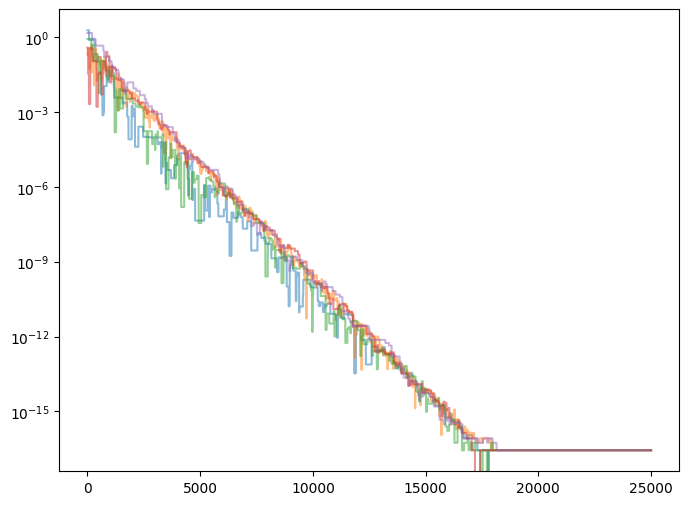

In [15]:
# plot xs
plt.figure(figsize=(8, 6))
xs = np.array(xs)
for i in range(5):
# for i in range(1):
    plt.semilogy(np.abs(xs[:25000, i]-mu_x), label=f'Node {i}', alpha=0.5)
    # plt.plot(xs[:25000, i]-mu_x, label=f'Node {i}', alpha=0.5)

In [16]:
def pdmm_average(
        x_init,        
        a,              
        G,               
        c=1.0,        
        max_iters=int(1e4)
    ):

    x = x_init.copy().astype(float)
    n = len(x)
    deg = np.array([G.degree[i] for i in range(n)])


    edges_dir = [(i, j) for i, j in G.edges()] + [(j, i) for i, j in G.edges()]
    z = {e: 0.0 for e in edges_dir}

    mu = a.mean()
    errors = []
    transmissions = []
    m_dir = len(edges_dir)              

    for k in range(max_iters):
        
        for i in range(n):
            s = sum(z[(i, j)] for j in G.neighbors(i))
            x[i] = (a[i] - s) / (1.0 + c * deg[i])


        errors.append(np.linalg.norm(x - mu) ** 2)



        y = {e: z[e] + 2.0 * c * x[e[0]] for e in edges_dir}
        for i, j in edges_dir:
            z[(j, i)] = -y[(i, j)]

        transmissions.append(transmissions[-1] + m_dir if transmissions else m_dir)

    return errors, transmissions


Best c: 0.11, Final error: 2.1120461924344289e-13


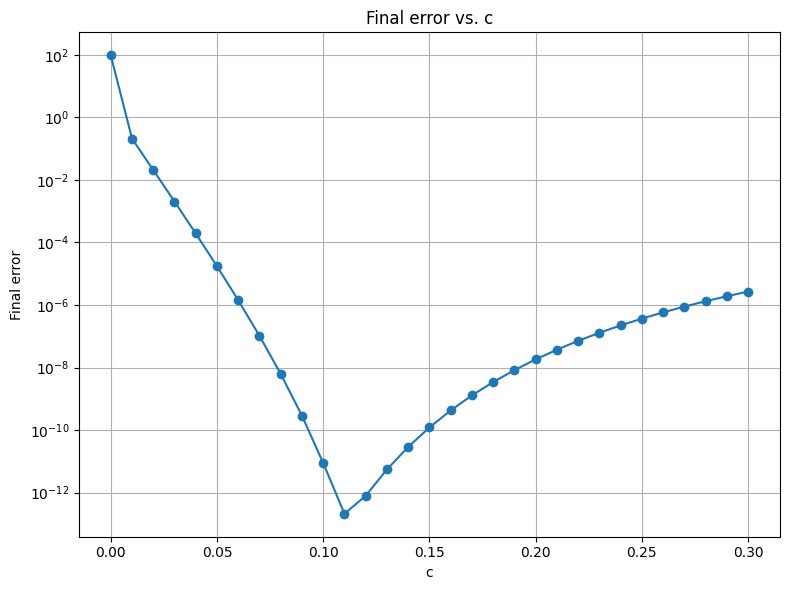

In [17]:
cs = np.linspace(0.0, 0.3, 31)

error_list_c = []
for c in cs:
    pdmm_err, pdmm_tx = pdmm_average(x_init, x_init, G, c=c, max_iters=int(5e1))
    error_list_c.append(pdmm_err[-1])

best_c = cs[np.argmin(error_list_c)]
print(f"Best c: {best_c}, Final error: {min(error_list_c)}")

plt.figure(figsize=(8, 6))
plt.semilogy(cs, error_list_c, marker='o')
plt.xlabel('c')
plt.ylabel('Final error')
plt.title('Final error vs. c')
plt.grid(True)
plt.tight_layout()

In [18]:
pdmm_err, pdmm_tx = pdmm_average(x_init, x_init, G, c=best_c, max_iters=int(5e1))


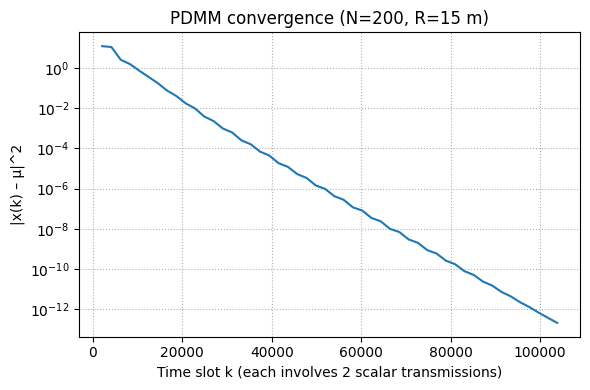

In [19]:
# ---------------- plot error vs. time slots (iterations) ----------------
plt.figure(figsize=(6,4))
plt.semilogy(pdmm_tx, pdmm_err, label='PDMM', linewidth=1.5)
plt.xlabel("Time slot k (each involves 2 scalar transmissions)")
plt.ylabel("|x(k) – μ|^2")
plt.title("PDMM convergence (N=200, R=15 m)")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()

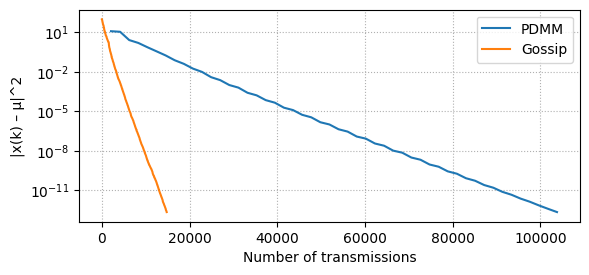

In [ ]:
# adjust y to plot them together
max_err = max(min(pdmm_err), min(errors))
# max_err float64 of 1e-10
# max_err = np.float64(1e-12)  # ensure it's a float for plotting

# plot range for pdmm
pdmm_idx = np.where(pdmm_err <= max_err)[0][0]
gossip_idx = np.where(errors   <= max_err)[0][0]
gossip_cum_tx = np.arange(len(errors)) * 2
# plot PDMM and gossip together
plt.figure(figsize=(6,5))
plt.semilogy(pdmm_tx[:pdmm_idx+1], pdmm_err[:pdmm_idx+1], label='PDMM', linewidth=1.5)
# plt.semilogy(errors[:gossip_idx+1], label='Gossip', linewidth=1.5)
plt.semilogy(gossip_cum_tx[:gossip_idx+1],errors[:gossip_idx+1], label='Gossip', linewidth=1.5)
plt.xlabel("Number of transmissions")
plt.ylabel("|x(k) – μ|^2")
# plt.title(f"Convergence of PDMM and Gossip (N={N}, R={R} m)")
plt.tight_layout()
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.gca().set_aspect(3000)
plt.savefig('imgs/convergence_pdmm_gossip.pdf', bbox_inches='tight')

### P3

In [21]:
import numpy as np
import networkx as nx
from tqdm import tqdm
def pdmm_median(
        x_init,     
        a,          
        G,    
        c=1.0,          
        max_iters=int(1e4)
    ):
    """
    Returns
    -------
    errors        : list[float] -- squared 2-norm  ||x(k) – median(a)||²
    transmissions : list[int]   -- cumulative scalar messages
    x             : np.ndarray  -- final node values
    """
    # ---------- initialisation -------------------------------------------
    x   = x_init.copy().astype(float)
    n   = len(x)
    deg = np.array([G.degree[i] for i in range(n)], dtype=float)

    edges_dir = [(i, j) for i, j in G.edges()] + [(j, i) for i, j in G.edges()]
    z = {e: 0.0 for e in edges_dir}
    per_iter_tx = len(edges_dir)          # 2 · |E| scalars per PDMM sweep

    target_med = float(np.median(a))
    errors, transmissions = [], []

    # ---------- main loop -------------------------------------------------
    bar = tqdm(range(max_iters), desc="PDMM Median", unit="iter", leave=False)
    
    
    # c_init = c
    # c_last = c_init * 10
    # c_scale = np.exp(np.log(c_last / c_init) / max_iters)  # exponential scaling
    # for _ in range(max_iters):
    for k in bar:
        # ----- 1) x-update --------------------------------------------------
        for i in range(n):
            # if k>= max_iters // 2:
            #     c = c+0.1
            S  = sum(z[(i, j)] for j in G.neighbors(i))
            cd = c * deg[i] 

            x_plus  = -(S + 1.0) / cd
            x_minus = -(S - 1.0) / cd

            if x_plus > a[i]:
                x[i] = x_plus
            elif x_minus < a[i]:
                x[i] = x_minus
            else:
                x[i] = a[i]

        # ----- 2) metrics ---------------------------------------------------
        errors.append(float(np.linalg.norm(x - target_med) ** 2))

        # ----- 3) y / z updates & messaging --------------------------------
        y = {e: z[e] + 2.0 * c * x[e[0]] for e in edges_dir}
        for i, j in edges_dir:
            z[(j, i)] = -y[(i, j)]

        transmissions.append(
            transmissions[-1] + per_iter_tx if transmissions else per_iter_tx
        )

        # progress-bar diagnostics every 100 iters
        if k % 10 == 0:
            bar.set_postfix(
                error  = f"{errors[-1]:.4e}",
                mean_x = f"{x.mean():.4f}",
                std_x  = f"{x.std():.4f}",
                median = f"{target_med:.4f}"
            )
    return errors, transmissions, x


ModuleNotFoundError: No module named 'tqdm'

In [ ]:
a = x_init.copy()  # fixed observations
med_err, med_tx, x_pdmm_med = pdmm_median(x_init, a, G, c=20)
# print(f"Final PDMM median: {x_pdmm_med.mean():.4f} (target median: {float(np.median(a)):.4f})")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.semilogy(med_tx, med_err, lw=1.5, label="PDMM-median")
plt.xlabel("Cumulative scalar transmissions")
plt.ylabel(r"$\|x(k)-x^*\|^2$")
plt.title("PDMM-median convergence")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout(); plt.legend(); plt.show()
